In [1]:
import os
import numpy as np
import math
import cv2
import glob
from  matplotlib import pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
print(tf.__version__)
'''
https://www.tensorflow.org/tutorials/load_data/images
從磁碟機讀取 image dataset方法
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

2.3.1


In [2]:
# dataset
validation_dir=r'C:\Users\user\chou_paper_data\flower_data\valid'  # testing data
train_dir=r'C:\Users\user\chou_paper_data\flower_data\train'  # training data
test_dir=r'C:\Users\user\chou_paper_data\flower_data\test'  # test data
batch_size=32
img_size=(227, 227)
freeze_layers_number=0
classes=sorted([o for o in os.listdir(train_dir)])  # 根据文件名分类

import requests
import json
file_location=r'C:\Users\user\chou_paper_data\flower_data\cat_to_name.json'
f=open(file_location)
class_names=json.loads(f.read())
class_names = {int(k):v for k,v in class_names.items()}

nb_train_samples = len(glob.glob(train_dir + '/*/*.*'))  # number of training data
nb_validation_samples = len(glob.glob(validation_dir + '/*/*.*'))  # number of validing data
nb_test_samples = len(glob.glob(test_dir + '/*.*'))  # number of test data
print(nb_train_samples,nb_validation_samples,nb_test_samples,'total=',nb_train_samples+nb_validation_samples+nb_test_samples)
'''
data set:
    Oxfordflower-102 public data set, which comes from the flower image database created by the Oxford University Visual Geometry Group.

    https://www.robots.ox.ac.uk/~vgg/data/flowers/102/
'''

6552 818 819 total= 8189


'\ndata set:\n    Oxfordflower-102 public data set, which comes from the flower image database created by the Oxford University Visual Geometry Group.\n\n    https://www.robots.ox.ac.uk/~vgg/data/flowers/102/\n'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 5283 images belonging to 102 classes.
Found 1269 images belonging to 102 classes.


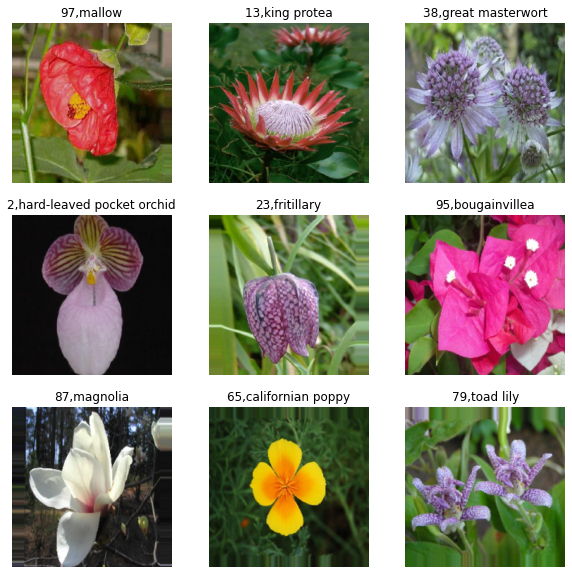

In [4]:
from scipy import ndimage
import scipy.interpolate
datas,labels = train_generator.next()
true_labels=[np.argmax(labels)for labels in labels]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(datas[i])
    plt.title(classes[true_labels[i]]+','+class_names[int(classes[true_labels[i]])])
    plt.axis("off")

In [16]:
def AlexNet(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    X = Flatten()(X)
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    X = Dense(102,activation='softmax',name = 'fc2')(X)
    model = Model(inputs = X_input, outputs = X, name='AlexNet')
    return model
model=AlexNet(train_generator[0][0].shape[1:])
model.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv0 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 55, 55, 96)        384       
_________________________________________________________________
activation_15 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max0 (MaxPooling2D)          (None, 27, 27, 96)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 27, 27, 256)       1024

In [17]:
num_epoch=100

optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.6, nesterov=True, name='SGD')

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(verbose=1, patience=5, min_delta=1e-4, monitor='val_accuracy')
callbacks = [early_stopping]

history=model.fit(train_generator,
                  steps_per_epoch=None,
                  validation_data=validation_generator,
                  validation_steps=None,
                  epochs=num_epoch,
                  callbacks=callbacks)

print('Training is finished!')

Epoch 1/100
166/166 [==============================] - 104s 627ms/step - loss: 4.5086 - accuracy: 0.0587 - val_loss: 4.5812 - val_accuracy: 0.0236
Epoch 2/100
166/166 [==============================] - 104s 626ms/step - loss: 4.0156 - accuracy: 0.1225 - val_loss: 4.5129 - val_accuracy: 0.0362
Epoch 3/100
166/166 [==============================] - 104s 625ms/step - loss: 3.7339 - accuracy: 0.1749 - val_loss: 4.1026 - val_accuracy: 0.0898
Epoch 4/100
166/166 [==============================] - 110s 664ms/step - loss: 3.4988 - accuracy: 0.2088 - val_loss: 3.6364 - val_accuracy: 0.1608
Epoch 5/100
166/166 [==============================] - 112s 673ms/step - loss: 3.3189 - accuracy: 0.2359 - val_loss: 3.3865 - val_accuracy: 0.2167
Epoch 6/100
166/166 [==============================] - 111s 670ms/step - loss: 3.1594 - accuracy: 0.2671 - val_loss: 3.2574 - val_accuracy: 0.2427
Epoch 7/100
166/166 [==============================] - 110s 662ms/step - loss: 3.0010 - accuracy: 0.3021 - val_loss: 3

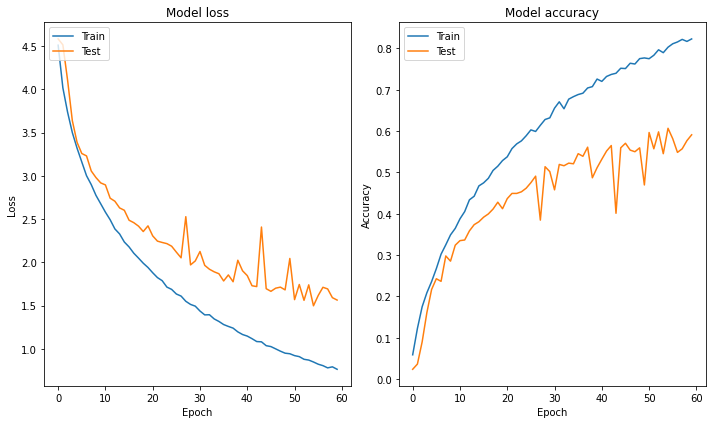

In [44]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,6), ncols=2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss']) 
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')
ax1.set_title(f'Model loss')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')
ax2.set_title(f'Model accuracy')
plt.tight_layout()
plt.savefig(r'C:\Users\user\fc_alexnet_hitroy.jpg')

In [46]:
model.save('fc_alexnet.h5')

In [6]:
'''
model.save('fc_alexnet.h5')
'''
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\user\desktop\fc_alexnet.h5')

In [23]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
file_path=r'C:\Users\user\chou_paper_data\flower_data\valid'
label_path=r'2'
image_path=r'image_05094.jpg'
orig_image = cv2.imread(file_path+'\\'+label_path+'\\'+image_path)
test_image=(orig_image)
test_image2=test_image/255
print(test_image2)
test_image = cv2.normalize(test_image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
print(test_image)
pred_image=cv2.resize(test_image,img_size)



pred_image = pred_image[None]
y = model.predict(pred_image)

[[[0.30588235 0.0627451  0.03921569]
  [0.30980392 0.06666667 0.04313725]
  [0.30980392 0.06666667 0.04313725]
  ...
  [0.44705882 0.14901961 0.1254902 ]
  [0.43529412 0.1372549  0.11372549]
  [0.43529412 0.1372549  0.11372549]]

 [[0.30588235 0.0627451  0.03921569]
  [0.30980392 0.06666667 0.04313725]
  [0.30980392 0.06666667 0.04313725]
  ...
  [0.45490196 0.15686275 0.13333333]
  [0.44705882 0.14901961 0.1254902 ]
  [0.44313725 0.14509804 0.12156863]]

 [[0.32156863 0.07843137 0.05490196]
  [0.32156863 0.07843137 0.05490196]
  [0.3254902  0.08235294 0.05882353]
  ...
  [0.45490196 0.15686275 0.13333333]
  [0.44705882 0.14901961 0.1254902 ]
  [0.44313725 0.14509804 0.12156863]]

 ...

 [[0.45882353 0.25098039 0.2627451 ]
  [0.45490196 0.24705882 0.25882353]
  [0.45098039 0.24313725 0.25490196]
  ...
  [0.41568627 0.1372549  0.1254902 ]
  [0.41960784 0.14117647 0.12941176]
  [0.42352941 0.14509804 0.13333333]]

 [[0.45098039 0.24313725 0.25490196]
  [0.44705882 0.23921569 0.25098039]


82:46.62%
2:9.46%
77:7.96%
98:7.60%
18:4.63%


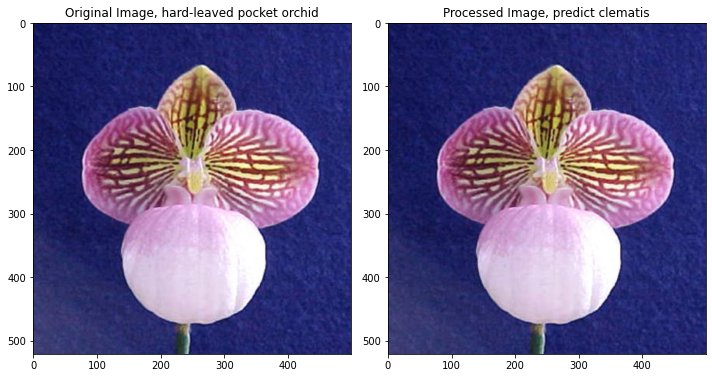

In [20]:
for i in np.argsort(y[0])[::-1][:5]:
    print('{}:{:.2f}%'.format(classes[i], y[0][i] * 100))

predict_label=classes[np.argsort(y[0])[::-1][0]]

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(orig_image[:, :, [2, 1, 0]])
ax1.set_title(f'Original Image, {class_names[int(label_path)]}')
ax2.imshow(test_image[:, :, [2, 1, 0]])
ax2.set_title(f'Processed Image, predict {class_names[int(predict_label)]}')
plt.tight_layout()
filename=image_path
plt.savefig(r'C:\Users\User\Downloads'+'\\'+filename)
plt.show()

In [21]:
preds = model.evaluate(validation_generator)

40/40 [==============================] - 18s 456ms/step - loss: 1.5694 - accuracy: 0.5973


In [22]:
import time
start=time.time()
num=0
acc=0
for root, dirs, files in os.walk(r'C:\Users\user\chou_paper_data\flower_data\valid',topdown=False):
    for name in files:
        orig_image = cv2.imread(os.path.join(root,name))
        test_image=(orig_image)
        test_image = cv2.normalize(test_image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        pred_image=cv2.resize(test_image,img_size)
        
        pred_image = pred_image[None]
        y = model.predict(pred_image)
        
        predict_label=classes[np.argsort(y[0])[::-1][0]]

        file=os.path.basename(os.path.dirname(os.path.dirname(root)))
        #print('file')
        subfile_l1=os.path.basename(os.path.dirname(root))
        #print('sub',subfile_l1) #train, test, validation
        subfile_l2=os.path.basename(root)
        #print('sub',subfile_l2) #label
        
        fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
        ax1.imshow(orig_image[:, :, [2, 1, 0]])
        ax1.set_title(f'Original Image, {class_names[int(subfile_l2)]}')
        ax2.imshow(test_image[:, :, [2, 1, 0]])
        #(outputdata*255).astype(np.float64)
        ax2.set_title(f'Processed Image, predict {class_names[int(predict_label)]}')
        plt.tight_layout()
        
        write_path=os.path.abspath(os.path.join(root, "../.."))+'_predict fc_alexnet'
        
        #print(name) #image name
        #print('write_path',write_path)
        
        if subfile_l2==predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_true')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true')
            if os.path.exists(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)

            plt.savefig(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2+'\\'+name)
            acc+=1
        if subfile_l2!=predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_false')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false')
            if os.path.exists(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)
            
            plt.savefig(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2+'\\'+name)
        plt.close()
        num+=1
end=time.time()
print('accuracy=',acc/num)
print(end-start)

accuracy= 0.14792176039119803
356.4504508972168
